In [2]:
!pip install mendelai-brat-parser

  Preparing metadata (setup.py) ... done
  Created wheel for mendelai-brat-parser: filename=mendelai_brat_parser-0.0.11-py3-none-any.whl size=4945 sha256=d7693f39f9a5f691e03a422f1ef86741190bc7a294914479900aef27a7d123d9
  Stored in directory: /root/.cache/pip/wheels/7e/40/73/4f68f4fa597be33e250400cd56c28c85862b1cba5b3c7c33f1
Successfully built mendelai-brat-parser


In [32]:
!unzip /src/olegbobrov/rurebus/RuREBus/train_data/train_part_3.zip 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Archive:  /src/olegbobrov/rurebus/RuREBus/train_data/train_part_3.zip
   creating: train_part_3/
  inflating: train_part_3/20103011022200910379001_0_part_5.ann  
  inflating: train_part_3/20103011022200910379001_0_part_5.txt  
  inflating: train_part_3/20336011022200910379002_6_part_0.ann  
  inflating: train_part_3/20336011022200910379002_6_part_0.txt  
  inflating: train_part_3/20336011022200910379002_6_part_1.ann  
  inflating: train_part_3/20336011022200910379002_6_part_1.txt  
  inflating: train_part_3/20336011022200910379002_6_part_2.ann  
  inflating: train_part_3/20336011022200910379002_6_part_2.txt  
  inflating: train_part_3/20336011022200910379002_6_part_3.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from brat_parser import get_entities_relations_attributes_groups
import glob
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
from dataclasses import dataclass
from tqdm import tqdm
import os
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
import pickle

In [2]:
def make_re_dataset(*, num_negatives_per_file_square_root=0):
    dataset = []
    for file in tqdm(glob.glob("train_part_1/*.ann") + glob.glob("train_part_2/*.ann") + glob.glob("train_part_3/*.ann")):
        txt_file_name = file.rstrip(".ann") + ".txt"
        with open(txt_file_name, "r") as f:
            txt = f.read()
        entities, relations, attributes, groups = get_entities_relations_attributes_groups(file)
        used_entities = set()
        for _id, relation in relations.items():
            used_entities.add(relation.subj)
            used_entities.add(relation.obj)
            
            subj = entities[relation.subj]
            obj = entities[relation.obj]
            label = relation.type
            part_min, part_max = min(subj.span[0][0], obj.span[0][0]), max(subj.span[0][1], obj.span[0][1])
            dataset.append((
                txt[part_min:part_max],
                subj.text,
                obj.text,
                subj.span[0][0] < obj.span[0][0],
                label
            ))
        if num_negatives_per_file_square_root:
            samples = [v for k, v in entities.items() if k not in used_entities]
            drawn = np.random.choice(samples, num_negatives_per_file_square_root)
            for fst in sorted(drawn, key=lambda x: x.span[0][0]):
                for snd in sorted(drawn, key=lambda x: x.span[0][0]):
                    if fst.span[0][0] >= snd.span[0][0]:
                        continue
                    dataset.append((
                        fst.text + ' ' + snd.text,
                        fst.text,
                        snd.text,
                        True,
                        "NO_RE"
                    ))
    return dataset

In [3]:
data = make_re_dataset(num_negatives_per_file_square_root=8)

100%|████████████████████████████████████████| 188/188 [00:00<00:00, 261.59it/s]


In [53]:
@dataclass
class ReEntity:
    token: str
    embeddings: list

def infer_and_merge_embeddings(tokenizer, model, dataset, disable_tqdm=False):
    model.eval()
    def merge_tokens(tokens, embeddings=None):
        assert embeddings is None or len(tokens.tokens()) == len(embeddings)
        result = []
        for i, token in enumerate(tokens.tokens()):
            if token.startswith('##'):
                result[-1].token += token.lstrip('##')
                if embeddings is not None:
                    result[-1].embeddings.append(embeddings[i].unsqueeze(0))
            else:
                result.append(ReEntity(token, []))
                if embeddings is not None:
                    result[-1].embeddings.append(embeddings[i].unsqueeze(0))
        return tuple(zip(*list(map(lambda entity: (entity.token, torch.cat(entity.embeddings).mean(dim=0) if embeddings is not None else -1), result))))
    
    def get_sub_idx(find_in, to_find):
        l1, l2 = len(find_in), len(to_find)
        for i in range(l1):
            if find_in[i:i+l2] == to_find:
                return i
        raise Exception(f"Something went wrong. Cannot find {to_find} in {find_in}")
    result = []
    bar = dataset if disable_tqdm else tqdm(dataset)
    for text, subj, obj, is_subj_first, label in bar:
        tokenized_text = tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            embeddings = model(**tokenized_text, output_hidden_states=True).hidden_states[-3][0]
        tokenized_subj = tokenizer(subj)
        tokenized_obj = tokenizer(obj)
        
        merged_tokens, merged_embeddings = merge_tokens(tokenized_text, embeddings)
        merged_tokens, merged_embeddings = merged_tokens[:-1], merged_embeddings[:-1] # drop SEP
        
        merged_subj, _ = merge_tokens(tokenized_subj) 
        merged_obj, _ = merge_tokens(tokenized_obj)
        
        merged_subj = merged_subj[1:-1] # drop CLS and SEP
        merged_obj = merged_obj[1:-1] # drop CLS and SEP
        
        cls_embed = merged_embeddings[0]
        subj_start_idx = get_sub_idx(merged_tokens, merged_subj)
        obj_start_idx = get_sub_idx(merged_tokens, merged_obj)
        result.append((cls_embed, merged_subj, merged_embeddings[subj_start_idx:subj_start_idx + len(merged_subj)],
                       merged_obj, merged_embeddings[obj_start_idx:obj_start_idx + len(merged_obj)], is_subj_first, label))
    return result

In [5]:
tokenizer = AutoTokenizer.from_pretrained("surdan/LaBSE_ner_nerel")
model = AutoModelForTokenClassification.from_pretrained("surdan/LaBSE_ner_nerel")

In [130]:
extracted = infer_and_merge_embeddings(tokenizer, model, data)

100%|█████████████████████████████████████| 17818/17818 [37:21<00:00,  7.95it/s]


In [131]:
with open('re_dataset_with_negatives.pickle', 'wb') as handle:
    pickle.dump(extracted, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open('re_dataset_with_negatives.pickle', 'rb') as handle:
    extracted = pickle.load(handle)

In [7]:
idx2label = dict(enumerate(set(filter(lambda x: x != "NO_RE", map(lambda x: x[6], extracted)))))
idx2label = {**idx2label, 11: "NO_RE"}
label2idx = {v: k for k, v in idx2label.items()}

In [8]:
idx2label

{0: 'PPS',
 1: 'GOL',
 2: 'TSK',
 3: 'NPS',
 4: 'FNT',
 5: 'PNT',
 6: 'FNG',
 7: 'NNT',
 8: 'FPS',
 9: 'NNG',
 10: 'PNG',
 11: 'NO_RE'}

In [9]:
class ReDataset(torch_data.Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.data[idx]

In [10]:
train_dataset = ReDataset(extracted)

In [11]:
def re_collate(batch):
    (cls_embeds, subj, subj_embeds, obj, obj_embeds, is_subj_first, label) = zip(*batch)
    clses = torch.stack(cls_embeds)
    subjects_embs = torch.stack(list(map(lambda x: torch.stack(x).mean(dim=0), subj_embeds)))
    objects_embs = torch.stack(list(map(lambda x: torch.stack(x).mean(dim=0), obj_embeds)))
    labels = torch.tensor(list(map(lambda x: label2idx[x], label)))

    return clses, subjects_embs, objects_embs, labels

In [562]:
def re_collate_no_mean(batch):
    import itertools
    (cls_embeds, subj, subj_embeds, obj, obj_embeds, is_subj_first, label) = zip(*batch)
    clses = torch.stack(cls_embeds)
    # subjects_embs = list(map(lambda x: torch.stack(x), subj_embeds))
    # objects_embs  = list(map(lambda x: torch.stack(x), obj_embeds))
    all_subjects = []
    all_objects = []
    all_labels = []
    all_clses = []
    for c, s, o, l in zip(cls_embeds, subj_embeds, obj_embeds, label):
        classes, subjects, objects = tuple(zip(*list(itertools.product([c], s, o))))
        all_subjects += subjects
        all_objects += objects
        all_clses += classes
        all_labels.append(torch.full((len(subjects), ), label2idx[l]))
    labels = torch.tensor(list(map(lambda x: label2idx[x], label)))
    return torch.stack(all_clses), torch.stack(all_subjects), torch.stack(all_objects), torch.cat(all_labels)

In [563]:
data_loader = torch_data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, collate_fn=re_collate, num_workers=8)

In [564]:
# data_loader = torch_data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, collate_fn=re_collate_no_mean, num_workers=8)

In [566]:
class ReClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.relation_classifier = nn.Sequential(
            nn.Linear(3 * input_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        self.has_relation = nn.Sequential(
            nn.Linear(3 * input_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )
    
    def forward(self, cls_emb, subj_emb, obj_emb):
        x = torch.cat([cls_emb, subj_emb, obj_emb], dim=1)
        relation_logits = self.relation_classifier(x)
        has_relation    = self.has_relation(x)
        return relation_logits, has_relation

In [567]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [568]:
epochs = 1000
criterion_relations = nn.CrossEntropyLoss()
criterion_has_relation = nn.BCEWithLogitsLoss()
classifier = ReClassifier(768, len(label2idx) - 1).cuda().train()
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.5)
NO_RELATION = label2idx["NO_RE"]

In [569]:
bar = tqdm(range(epochs))
losses = []
for epoch in bar:
    train_loss = 0
    cnt = 0
    for batch in data_loader:
        optimizer.zero_grad()
        clses, subjects_embs, objects_embs, labels = tuple(map(lambda x: x.cuda(), batch))
        relation_pred, has_relation_pred = classifier(clses, subjects_embs, objects_embs)
        has_relation_mask = torch.ones(labels.shape).float().cuda()
        has_relation_mask[labels == NO_RELATION] = 0
        loss = criterion_relations(relation_pred[labels != NO_RELATION], labels[labels != NO_RELATION]) + \
               criterion_has_relation(has_relation_pred, has_relation_mask.unsqueeze(-1))
        
        train_loss += loss.item()
        cnt += 1
        
        loss.backward()
        optimizer.step()
    scheduler.step()
    bar.set_description(f"Last epoch [{epoch + 1}]: train_loss [{train_loss / cnt}]")
    losses.append(train_loss / cnt) # 0.3209

Last epoch [1000]: train_loss [0.35484316774777]: 100%|█| 1000/1000 [43:01<00:00


In [570]:
torch.save(classifier.state_dict(), 're_classifier_large_final_epochs=500_lr=1e-3_stepsize=250_gamma=0.1.model')

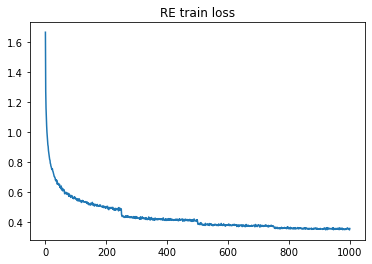

In [571]:
plt.plot(losses)
plt.title('RE train loss')
plt.show()

In [529]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [530]:
classifier.eval()

ReClassifier(
  (relation_classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=512, out_features=11, bias=True)
  )
  (has_relation): Sequential(
    (0): Linear(in_features=2304, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [572]:
from sklearn.metrics import accuracy_score

def get_accuracy_on_loader(loader):
    all_labels = []
    all_relations  = []
    all_has_relations  = []
    with torch.no_grad():
        classifier.eval()
        for batch in tqdm(loader):
            clses, subjects_embs, objects_embs, labels = list(map(lambda x: x.cuda(), batch))
            relation, has_relation = classifier(clses, subjects_embs, objects_embs)
            all_relations.append(relation.argmax(dim=1).detach().cpu().numpy())
            all_has_relations.append(torch.sigmoid(has_relation).squeeze().detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())
    all_labels, all_relations, all_has_relations = np.concatenate(all_labels), np.concatenate(all_relations), np.concatenate(all_has_relations)
    return all_labels, all_relations, all_has_relations

In [573]:
train_labels, train_preds_relations, train_preds_has_relations = get_accuracy_on_loader(data_loader)

100%|███████████████████████████████████████████| 70/70 [00:02<00:00, 25.49it/s]


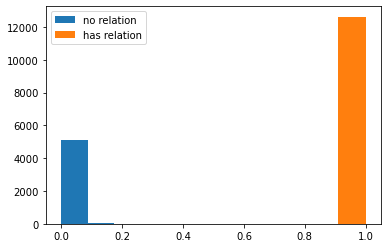

In [574]:
plt.hist(train_preds_has_relations[train_labels == NO_RELATION], label="no relation")
plt.hist(train_preds_has_relations[train_labels != NO_RELATION], label="has relation")
plt.legend()
plt.show()

In [575]:
def find_relations(classifier, bert, tokenizer, text, has_relation_treshold=0.5, visualizer=None):
    def pack_dataset(text, subj, obj):
        return [
            (text, subj, obj, True, "TSK")
        ]
    classifier.eval()
    bert.eval()
    answer = []
    tokenized = tokenizer(text)
    tokens = tokenized.tokens()
    seen = set()
    for subj_idx, subj_token in enumerate(tokens):
        if subj_idx == 0 or subj_idx == len(tokens):
            continue
        for obj_idx in range(subj_idx + 1, len(tokens) - 1):
            subj_start, subj_end = tokenized.word_to_chars(tokenized.token_to_word(subj_idx))
            obj_start, obj_end   = tokenized.word_to_chars(tokenized.token_to_word(obj_idx))
            if subj_start == obj_start and subj_end == obj_end or ((subj_start, subj_end), (obj_start, obj_end)) in seen:
                continue
            seen.add(((subj_start, subj_end), (obj_start, obj_end)))
            subj, obj = text[subj_start:subj_end], text[obj_start:obj_end]
            packed = pack_dataset(text, subj, obj)
            preprocess = infer_and_merge_embeddings(tokenizer, bert, packed, disable_tqdm=True)
            clses, subjects_embs, objects_embs, labels = list(map(lambda x: x.cuda(), re_collate(preprocess)))
            with torch.no_grad():
                relation_to, has_relation_to = classifier(clses, subjects_embs, objects_embs)
                relation_from, has_relation_from = classifier(clses, objects_embs, subjects_embs)
                has_relation_to_score = torch.sigmoid(has_relation_to).item()
                has_relation_from_score = torch.sigmoid(has_relation_from).item()
                if has_relation_to_score < has_relation_treshold and has_relation_from_score < has_relation_treshold:
                    continue
                is_to_relation = has_relation_to_score > has_relation_from_score
                relation = relation_to if is_to_relation else relation_from
                distribution = nn.functional.softmax(relation.squeeze(), dim=0)
                label = distribution.argmax().item()
                confidence = distribution[label].item()
                if visualizer is not None:
                    from_vert = f"{subj}_{subj_idx}" if is_to_relation else f"{obj}_{obj_idx}"
                    to_vert = f"{subj}_{subj_idx}" if not is_to_relation else f"{obj}_{obj_idx}"
                    visualizer.add_edge(from_vert, to_vert, idx2label[label])
                print(confidence, max(has_relation_to_score, has_relation_from_score), idx2label[label], subj, obj)
    if visualizer is not None:
        visualizer.visualize()

In [576]:
import networkx as nx
import matplotlib.pyplot as plt

class GraphVisualization:

    def __init__(self):
        self.visual = []
        self.edge_labels = {}

    def add_edge(self, u, v, label):
        self.visual.append((u, v))
        self.edge_labels[(u, v)] = label
        
    def visualize(self):
        G = nx.DiGraph()
        G.add_edges_from(self.visual)
        
        pos = nx.kamada_kawai_layout(G)
        plt.figure(figsize =(9, 9))
        nx.draw(G, pos, with_labels=True)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=self.edge_labels, font_size=25)
        nx.draw_networkx(G, 
                     node_color =['C{}'.format(i) for i, _ in enumerate(pos)], 
                     pos=pos, 
                      node_size=[len(i)**2 * 60 for i in list(G.nodes())]
                    )

1.0 1.0 PPS Зарплаты повысили


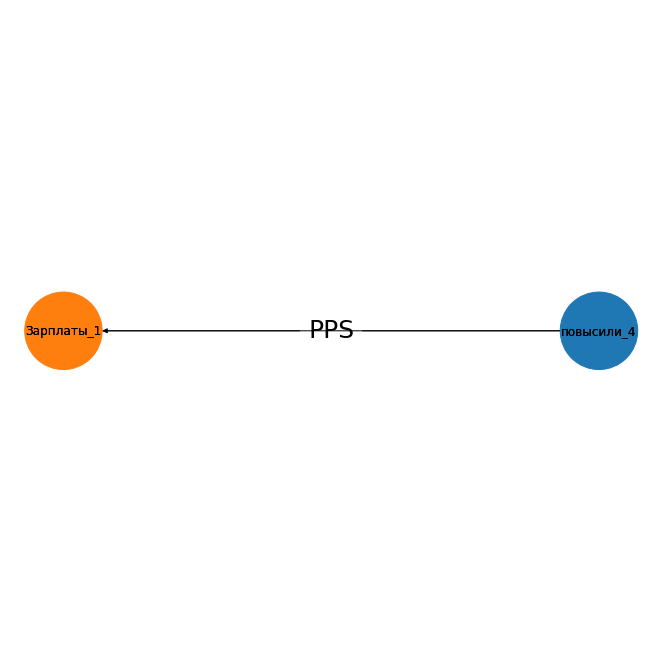

In [577]:
v = GraphVisualization()
find_relations(classifier, model, tokenizer, "Зарплаты повысили", has_relation_treshold=0.8, visualizer=v)

0.999321460723877 1.0 PPS Вырос уровень
0.9999998807907104 1.0 PPS Вырос бедности
0.7371683120727539 1.0 PPS Вырос .
0.9681594371795654 1.0 NNG уровень бедности
0.791618287563324 0.9999992847442627 NNG уровень .
0.9446114897727966 1.0 NNG бедности .


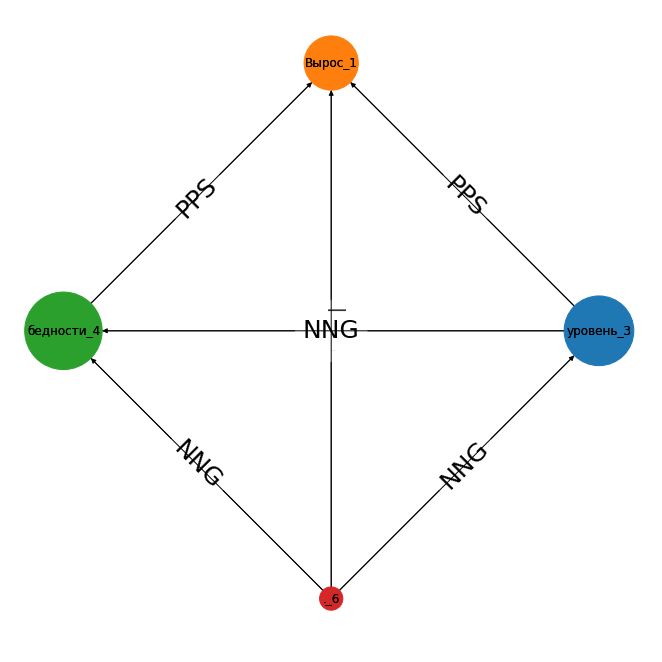

In [578]:
v = GraphVisualization()
find_relations(classifier, model, tokenizer, "Вырос уровень бедности.", has_relation_treshold=0.8, visualizer=v)

0.5855001211166382 1.0 FPS Увеличить количество
0.998432457447052 1.0 FPS Увеличить волонтеров
0.9880498051643372 1.0 FPS Увеличить анти
0.8075233101844788 0.9995144605636597 TSK Увеличить наркотической
0.9861063957214355 1.0 NNT Увеличить направленности
0.8602930903434753 1.0 FPS количество волонтеров
0.9998775720596313 0.9999986886978149 NPS количество анти
0.9996360540390015 1.0 NPS количество направленности
0.9999879598617554 1.0 NPS волонтеров анти
1.0 0.9822428226470947 FPS волонтеров наркотической
0.9183101654052734 1.0 NNG волонтеров направленности
0.9655349254608154 0.9841687679290771 NNG наркотической направленности


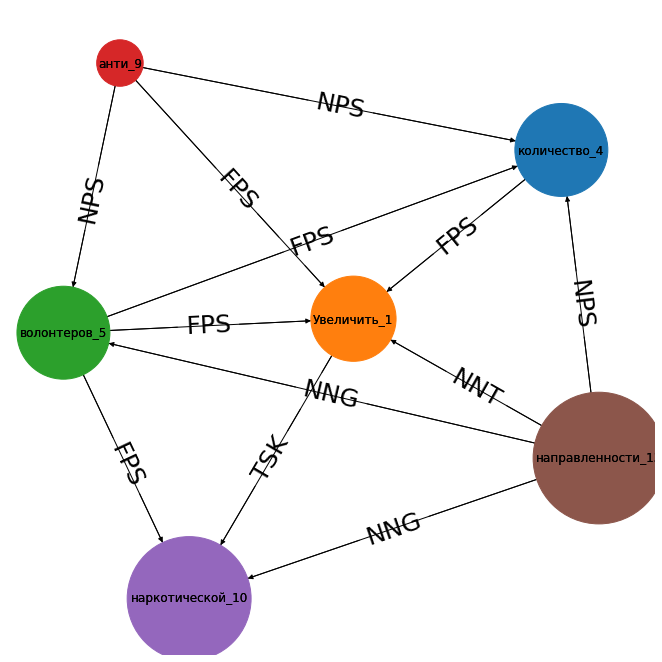

In [579]:
g = GraphVisualization()
find_relations(classifier, model, tokenizer, "Увеличить количество волонтеров анти  наркотической направленности", 
               has_relation_treshold=0.8, visualizer=g)

1.0 1.0 FNT Мы планируем
0.9999293088912964 1.0 FNT Мы увеличить
0.9996590614318848 1.0 FNT Мы количество
0.9904749989509583 1.0 FPS Мы детей
0.5879403352737427 0.9998069405555725 FPS Мы и
0.9999998807907104 1.0 FPS Мы молодежи
0.8843333125114441 1.0 FNT планируем увеличить
0.9997819066047668 1.0 NNT планируем количество
0.9998292922973633 1.0 FPS планируем детей
0.9999847412109375 1.0 FPS планируем молодежи
0.9880708456039429 1.0 FPS увеличить количество
0.9999986886978149 1.0 FPS увеличить детей
1.0 1.0 FPS увеличить молодежи
0.9888848066329956 1.0 FPS количество детей
0.9998605251312256 1.0 FPS количество молодежи
1.0 0.8418412804603577 FPS детей и
0.9842529892921448 0.9999994039535522 GOL детей молодежи


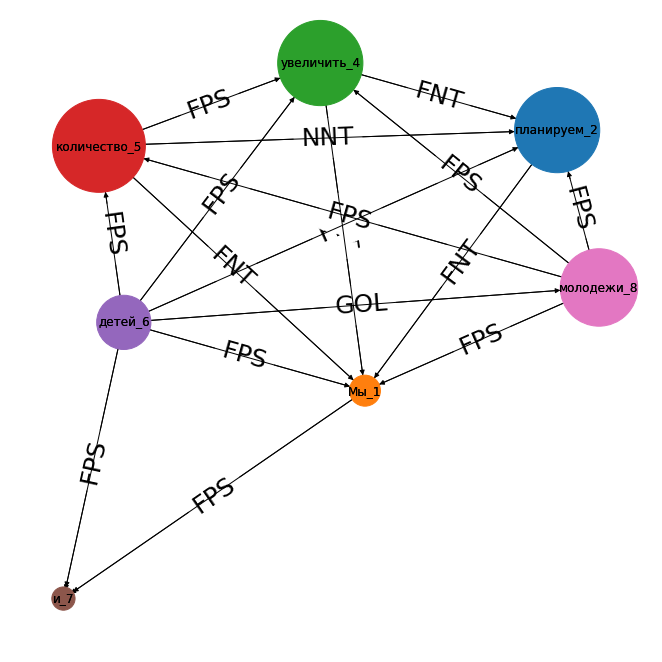

In [580]:
g = GraphVisualization()
find_relations(classifier, model, tokenizer, "Мы планируем увеличить количество детей и молодежи", 
               has_relation_treshold=0.8, visualizer=g)

0.9896785020828247 0.9999940395355225 NPS Количество народных
1.0 0.9584119319915771 NPS Количество дружинников
0.7160274982452393 1.0 NNT Количество УФКиМС


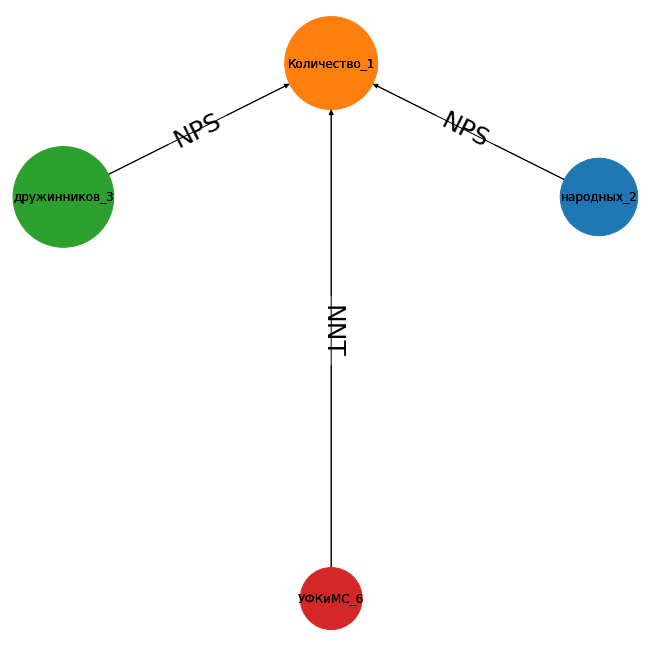

In [545]:
g = GraphVisualization()
find_relations(classifier, model, tokenizer, "Количество народных дружинников УФКиМС", 
               has_relation_treshold=0.8, visualizer=g)

In [581]:
!pwd

/src/olegbobrov/rurebus
